In [150]:
import numpy as np
from random import randint, random, choice
import matplotlib.pyplot as plt
from math import sqrt, log
%matplotlib inline

In [262]:
class Board(object):
    def __init__(self, num_players, rewards):
        self.n_players = num_players
        self.rewards = rewards
        self.grid = [[0 for i in range(16)] for j in range(16)]
        self.cur_turn = 1
        self.baseCamps = {2: [0, 0], 1: [15, 15]}
        self.this_turn_visited = []
        self.last_moved = [None, None]
        self.starting_positions = {}
        self.prevInPlace = 0
        if self.n_players == 2: 
            self.starting_positions[1] = [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3], [3, 0], [3, 1], [3, 2], [4, 0], [4, 1]] 
            self.starting_positions[2] = [[15, 11], [15, 12], [15, 13], [15, 14], [15, 15], [14, 11], [14, 12], [14, 13], [14, 14], [14, 15], [13, 12], [13, 13], [13, 14], [13, 15], [12, 13], [12, 14], [12, 15], [11, 14], [11, 15]] 
#         if self.cur_turn == 2:
#             self.opponentMove()
        
    def printBoard(self):
        for r in self.grid:
            print(r)
            
    def reset(self):
        self.grid = [[0 for i in range(16)] for j in range(16)]
        if self.n_players == 2: 
            for player, lst in self.starting_positions.items():
                 for x, y in lst:
                        self.grid[x][y] = player
    
#     def opponentMove(self):
#         opponent = Agent(self, 2, [15, 15])
#         opponent.move()
#         print("NOT COMPLETE")
    
    def checkWin(self, player):
        if self.n_players == 2:
            win_positions = self.starting_positions[self.n_players - player + 1]            
            for x, y in win_positions:
                if self.grid[x][y] != player:
                    return False
            return True
    
    def checkInPlace(self, reward = 10):
        piecesInPlace = 0
        if self.n_players == 2:
            win_positions = self.starting_positions[self.n_players - player + 1]            
            for x, y in win_positions:
                if self.grid[x][y] == player:
                    piecesInPlace += 100
#             inPlaceDiff = piecesInPlace - self.prevInPlace
#             self.prevInPlace = piecesInPlace
            for i in range(len(self.grid)):
                for j in range(len(self.grid[i])):
                    if self.grid[i][j] == self.cur_turn:
                        totalDist += self.checkDist(i, j)
            return inPlaceDiff * reward
    
    def calcTotalRew(self, reward = 10):
        totalDist = 0.
        for i in range(len(self.grid)):
            for j in range(len(self.grid[i])):
                if self.grid[i][j] == self.cur_turn:
                    totalDist += self.checkDist(i, j)
        return totalDist*reward
                        
    def inBounds(self, i, j):
        if i < 0 or j < 0 or j > 15 or i > 15:
            return False
        return True
    
    def checkDist(self, x, y, other = None):
        if not other:
            other = self.baseCamps[3-self.cur_turn]

        baseX, baseY = other
        return ((baseY - y)**2 + (baseX-x)**2)
    
    def getLegalComplete(self, i, j, positive = None):
        # BFS from i, j
        legal = {"moves": [], "jumps": []}
        if self.grid[i][j] == 0:
            print(i, j, self.grid[i])
            print("Why are you trying to move a blank space?")
            return legal
        else:
            visited = [[False for q in range(16)] for z in range(16)]
            queue = [[i, j]]
            while queue:
                x, y = queue.pop(0)
                if not visited[x][y]:
                    if [x, y] != [i, j]:
                        legal["jumps"].append([x, y])
                    for k in range(-1, 2):
                        for l in range(-1, 2):
                            if self.inBounds(x + 2*k, y + 2*l) and self.grid[x + 2*k][y + 2*l] == 0 and self.grid[x + k][y + l] != 0:        
                                    if not visited[x + 2*k][y + 2*l]: 
                                        queue.append([x + 2*k, y + 2*l])
                    visited[x][y] = True        

            for k in range(-1, 2):
                    for l in range(-1, 2):                    
                        if self.inBounds(i + k, j + l) and self.grid[i + k][j + l] == 0:
                            legal["moves"].append([i + k, j + l])
            return legal
            
    def getLegal(self, i, j, positive = None, jump = False):
        legal = {"moves": [], "jumps": []}
        if self.grid[i][j] == 0:
            print(i, j, self.grid[i])
            print("Why are you trying to move a blank space?")
            return legal
        else:
            for k in range(-1, 2):
                for l in range(-1, 2):
                    myDist = self.checkDist(i, j, other = positive)
                    if self.inBounds(i + 2*k, j + 2*l) and self.grid[i + 2*k][j + 2*l] == 0 \
                    and self.grid[i + k][j + l] != 0:
                        newDist = self.checkDist(i + 2*k, j + 2*l, other = positive)
                        if (myDist > newDist):
                            legal["jumps"].append([i + 2*k, j + 2*l, newDist])
                    if not jump:
                        if self.inBounds(i + k, j + l) and self.grid[i + k][j + l] == 0:
                            newDist = self.checkDist(i + k, j + l, other = positive)
                            if (myDist > newDist):
                                legal["moves"].append([i + k, j + l, newDist])
            return legal
            
    def checkLegal(self, player, i, j, k, l):
        if self.grid[k][l] != 0 or self.grid[i][j] != player:
#             if random() < 0.01:
#                 print("You can't do that move")
#                 print "Here's why. Grid at k, l isn't 0?:", k, l, self.grid[k][l], "Or at i, j, isn't player", player, i, j, self.grid[j][j]
            return False
        else:
            legal = self.getLegalComplete(i, j)
            # TODO - This currently doesn't work because the getLegal() above needs to be passed a proper 
            # value for "positive"
#             if [k, l] not in [[m[0], m[1]] for m in legal["moves"]] and \
#                 [k, l] not in [[m[0], m[1]] for m in legal["jumps"]]:
#                 print("Not legal move")
#                 print(i, j, k, l, legal)
#                 return False
            return True
            
    def move(self, player, i, j, k, l, pBoard = False):
        if self.checkLegal(player, i, j, k, l) == True and self.cur_turn == player:
            self.grid[i][j] = 0
            self.grid[k][l] = player
            
            # set last moved
            self.last_moved = [k, l]
            
            # record in our path
            if self.this_turn_visited == []:
                self.this_turn_visited.append([i, j])
            self.this_turn_visited.append([k, l])
            
            # check if we're able to move again
            new_moves = self.getLegal(k, l)
            
            # end turn if we didn't just jump and there are still legal jumps, and we didn't just move one space
            if not new_moves["jumps"] or (abs(k - i) != 2 and abs(l - j) != 2):
                self.cur_turn = 3 - self.cur_turn
                self.this_turn_visited = []
            
            if pBoard:
                self.printBoard()
        

In [218]:
board = Board(2, 0)
board.reset()
board.move(1, 0, 4, 0, 5)
board.printBoard()
print(board.getLegalComplete(2, 2))

[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2]
{'jumps': [[0, 4], [2, 4], [4, 2], [0, 6]], 'moves': [[3, 3]]}


In [219]:
class Agent(object):
    def __init__(self, board, ID, baseOrigin):
        self.ID = ID
        self.baseOrigin = baseOrigin
        self.board = board
        self.pieces = self.board.starting_positions[self.ID]
        self.overrideDist = False
    
    def updateBoard(self, board):
        self.board = board
    
    def findPieces(self, board):
        pieces = []
        for i in range(len(board.grid)):
            for j in range(len(board.grid[i])):
                if board.grid[i][j] == self.ID:
                    pieces.append([i, j])
        return pieces
    
    def distToOther(self, piece, other = None):
        if not other:
            other = self.baseOrigin
        baseX, baseY = other
        pieceX, pieceY = piece
        return ((baseY - pieceY)**2 + (baseX-pieceX)**2)**.5
    
    def bestPiece(self, distPieces = None, mp = None): 
        if not distPieces:
            distPieces = sorted([[self.distToOther(piece), piece] for piece in self.pieces])

        for piece in distPieces:
            i, j = piece[1]
            legals = self.board.getLegal(i, j, positive = mp)
            if legals["jumps"] or legals["moves"]:
                return [(i, j), legals]
        return [False, False]
    
    def bestMove(self, mustJump = None, eps = .2):
        if mustJump:
            piece = mustJump
            legals = self.board.getLegal(piece[0], piece[1], jump = True)
            
        elif self.overrideDist:
            # Find the pieces that are not in the right positions
            s = self.board.starting_positions[self.board.n_players-self.ID+1]
            missedPieces = [x for x in self.pieces if x not in s]
            
            # Find the first missing position
            missedPos = [x for x in s if x not in self.pieces]
            if not missedPos:
                print "Erroneous"
                return [False, False]
            mp = missedPos[0]
            
            # Calculate distances and find best move using those
            distPieces = sorted([[self.distToOther(piece, mp), piece] for piece in missedPieces], reverse=True)         
            piece, legals = self.bestPiece(distPieces = distPieces, mp = mp)
            
        else:
            piece, legals = self.bestPiece()
        
        if not piece or not legals:
            return [False, False]
        
        if legals["jumps"]:
            distJumps = sorted(legals["jumps"], reverse=True, key=lambda i: i[2])
            if random() < eps:
                target = choice(distJumps)
            else:
                target = distJumps[0]
            return [(piece[0], piece[1], target[0], target[1]), True]

        elif legals["moves"] and not mustJump:
            distMoves = sorted(legals["moves"], reverse=True, key=lambda i: i[2])
            if random() < eps:
                target = choice(distMoves)
            else:
                target = distMoves[0]
            return [(piece[0], piece[1], target[0], target[1]), False]
        
        else:
            return [False, False]
    
    def move(self):
        move, jumped = self.bestMove()
        
        # If no move available, clearly we are in a deadlock
        if not move:
            self.overrideDist = True
            move, jumped = self.bestMove()
            if not move:
                print self.ID, self.overrideDist
                return False
        
        # Make move on board and record pieces
        i, j, k, l = move
        self.board.move(self.ID, i, j, k, l)
        self.pieces = self.findPieces(self.board)
        
        # Continue jumping if already done so
        while jumped:
            move, jumped = self.bestMove(mustJump = [k, l])
            if move:
                i, j, k, l = move
                self.board.move(self.ID, i, j, k, l)
                self.pieces = self.findPieces(self.board)
        
        # Return the final move made
#         self.board.cur_turn = 3 - self.board.cur_turn
        return move

In [221]:
board = Board(2, 0)
board.reset()
opponent = Agent(board, 2, [15, 15])
player = Agent(board, 1, [0, 0])
for i in range(100):
    player.move()
    opponent.move()
        
board.printBoard()

(1, 1, [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Why are you trying to move a blank space?
(14, 14, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2])
Why are you trying to move a blank space?
(0, 2, [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Why are you trying to move a blank space?
(13, 15, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0])
Why are you trying to move a blank space?
(2, 0, [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Why are you trying to move a blank space?
(15, 13, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0])
Why are you trying to move a blank space?
(1, 2, [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Why are you trying to move a blank space?
(13, 14, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2])
Why are you trying to move a blank space?
(2, 1, [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Why are you trying to move a blank space?
(14, 13, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0])
Why are you trying to move a blank space?


In [72]:
moveRew = -1
winRew = 100
def PlayGame(nplayers = 2):
    brd = Board(nplayers, 0)
    brd.reset()
    opponent = Agent(brd, 2, [15, 15])
    player = Agent(brd, 1, [0, 0])
    players = [opponent, player]
    
# #     for i in range(250):
# #         opponent.move()
# #         player.move()

    rewards = {1: [], 2: []}
    m, m1 = 0, 0
    c = 0
    while True:
        for p in players:
            # Check if game is ended
            if brd.checkWin(p.ID):
                rewards[p.ID].append(winRew)
                return p, rewards
            m = p.move()
            rewards[p.ID].append(moveRew)
            brd = p.board
        c+=1

In [73]:
lol = PlayGame()

In [74]:
plays = 100

In [75]:
wins = {1: 0, 2: 0}
rews = {1: [], 2: []}
for i in range(plays):
    p, r = PlayGame()
    wins[p.ID] += 1
    rews[1].append(np.sum(r[1]))
    rews[2].append(np.sum(r[2]))
cumrews = {1: np.cumsum(rews[1]), 2: np.cumsum(rews[2])}

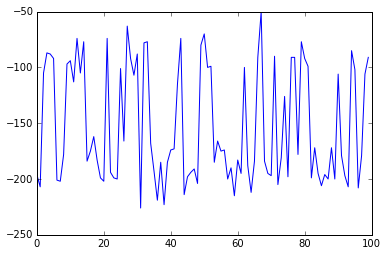

In [76]:
x = np.arange(0, plays, 1)
y = map(lambda x: rews[1][x], x)

plt.plot(x, y)

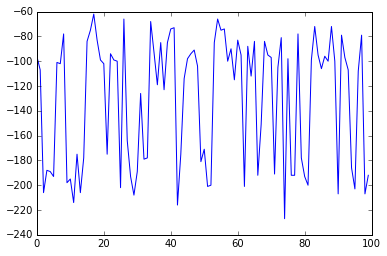

In [77]:
x = np.arange(0, plays, 1)
y = map(lambda x: rews[2][x], x)

plt.plot(x, y)

In [263]:
class HalmaState:
    """ A state of the game of Halma
    """
    def __init__(self, players = 2, rewards = 0):
        self.nplayers = 2
        self.rewards = 0
        self.board = Board(players, rewards)
        self.playerJustMoved = self.board.cur_turn 
        ## I changed this -> At the root pretend the player just moved is p2 - p1 has the first move
        self.board.reset()
        self.size = len(self.board.grid)

    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = HalmaState()
        st.playerJustMoved = self.playerJustMoved
        st.board.grid = [self.board.grid[i][:] for i in range(len(self.board.grid))]
        return st

    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerToMove.
        """
#         print move
        i, j, k, l = move
        self.board.move(self.board.cur_turn, i, j, k, l)
        self.playerJustMoved = self.board.cur_turn
#         self.board.cur_turn = 3 - self.board.cur_turn
    
    def GetMoves(self):
        """ Get all possible moves from this state.
        """
        moves = {"moves": [], "jumps": []}
        for i in range(len(self.board.grid)):
            for j in range(len(self.board.grid)):
                if self.board.grid[i][j] == self.playerJustMoved:
                    legals = self.board.getLegalComplete(i, j)
#                     print legals, self.playerJustMoved, self.board.cur_turn
                    
                    # remove places we've already traveled this turn if necessary
                    if legals["moves"]:
                        moves["moves"] += ([[i, j, k, l] for k, l in legals["moves"] if [k, l] not in self.board.this_turn_visited])
                    if legals["jumps"]:
                        moves["jumps"] += ([[i, j, k, l] for k, l in legals["jumps"] if [k, l] not in self.board.this_turn_visited])
        
        # Override
        if not moves["moves"] and not moves["jumps"]:
            # Find the pieces that are not in the right positions
            s = self.board.starting_positions[3 - self.playerJustMoved]
            
            # Find the first missing position
            missedPos = [[x,y] for x, y in s if self.board.grid[x][y] == 0]
            if missedPos:
                target = missedPos[0]
            else:
                return moves
            for i in range(len(self.board.grid)):
                for j in range(len(self.board.grid)):
                    if self.board.grid[i][j] == self.playerJustMoved:
                        legals = self.board.getLegalComplete(i, j, positive = target)
    #                     print legals, self.playerJustMoved, self.board.cur_turn

                        # remove places we've already traveled this turn if necessary
                        if legals["moves"]:
                            moves["moves"] += ([[i, j, k, l] for k, l in legals["moves"] if [k, l] not in self.board.this_turn_visited])
                        if legals["jumps"]:
                            moves["jumps"] += ([[i, j, k, l] for k, l in legals["jumps"] if [k, l] not in self.board.this_turn_visited])
        
        if not moves["moves"] and not moves["jumps"]:
            print "something went wrong"
        
        return moves
    
    def GetResult(self, player):
        """ Get the game result from the viewpoint of playerjm. 
        """
        reward = 10
        #return self.board.checkInPlace(player, reward)
        return self.board.calcTotalRew(reward)

    def __repr__(self):
        s= ""
        for x in range(len(self.board.grid)):
            for y in range(len(self.board.grid[x])):
                s += ["[_]","[X]","[O]"][self.board.grid[x][y]]
            s += "\n"
        return s

In [267]:
class Node:
    """ A node in the game tree. Note wins is always from the viewpoint of playerJustMoved.
        Crashes if state not specified.
    """
    def __init__(self, move = None, moveType = None, parent = None, state = None):
        self.move = move # the move that got us to this node - "None" for the root node
        self.moveType = moveType
        self.parentNode = parent # "None" for the root node
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.untriedMoves = state.GetMoves() # future child nodes
        self.playerJustMoved = state.playerJustMoved # the only part of the state that the Node needs later
        
    def UCTSelectChild(self):
        """ Use the UCB1 formula to select a child node. Often a constant UCTK is applied so we have
            lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits to vary the amount of
            exploration versus exploitation.
        """
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits))[-1]
        return s
    
    def AddChild(self, m, s, moveType = "moves"):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node
        """
        n = Node(move = m, moveType = moveType, parent = self, state = s)
        self.untriedMoves[moveType].remove(m)
        self.childNodes.append(n)
        return n
    
    def Update(self, result):
        """ Update this node - one additional visit and result additional wins. result must be from the viewpoint of playerJustmoved.
        """
        self.visits += 1
#         if result:
#             print "booom"
        self.wins = result

    def __repr__(self):
        return "[M:" + str(self.move) + " MT:" + str(self.moveType) + " W/V:" + str(self.wins) + "/" + str(self.visits) + " U:" + str(self.untriedMoves) + "]"

    def TreeToString(self, indent):
        s = self.IndentString(indent) + str(self)
        for c in self.childNodes:
             s += c.TreeToString(indent+1)
        return s

    def IndentString(self,indent):
        s = "\n"
        for i in range (1,indent+1):
            s += "| "
        return s

    def ChildrenToString(self):
        s = ""
        for c in self.childNodes:
             s += str(c) + "\n"
        return s

In [268]:
def UCT(rootstate, itermax, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
        Assumes 2 alternating players (player 1 starts), with game results in the range [0.0, 1.0]."""

    rootnode = Node(state = rootstate)

    for i in range(itermax):
        node = rootnode
        state = rootstate.Clone()

        # Select
        while not node.untriedMoves["moves"] and not node.untriedMoves["jumps"] and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
#             print str(state)
            state.DoMove(node.move)

        # Expand
        if node.untriedMoves["moves"] or node.untriedMoves["jumps"]: # if we can expand (i.e. state/node is non-terminal)
            m = choice(node.untriedMoves["moves"] + node.untriedMoves["jumps"])
            
#             if m in node.untriedMoves["moves"]:
#                 node.untriedMoves["moves"].remove(m)
#             elif m in node.untriedMoves["jumps"]:
#                 node.untriedMoves["jumps"].remove(m)
                
            state.DoMove(m)
            mt = "moves"
            if m in node.untriedMoves["jumps"]:
                mt = "jumps"
            node = node.AddChild(m, state, mt) # add child and descend tree
        
        mvs = state.GetMoves()
        if not mvs:
            return None
        asdf = 0
        # Rollout - this can often be made orders of magnitude quicker using a state.GetRandomMove() function
        while mvs["moves"] or mvs["jumps"]: # while state is non-terminal
#             print mvs
            mv = choice(mvs["moves"] + mvs["jumps"])
            if mv in mvs["moves"]:
                mvs["moves"].remove(mv)
            elif mv in mvs["jumps"]:
                mvs["jumps"].remove(mv)
            state.DoMove(mv)
#             if asdf > 20:
#                 return
#             asdf+=1

        # Backpropagate
        while node != None: # backpropagate from the expanded node and work back to the root node
            node.Update(state.GetResult(node.playerJustMoved)) # state is terminal. Update node with result from POV of node.playerJustMoved
            node = node.parentNode
        
#         if i > 2:
#             return

    # Output some information about the tree - can be omitted
    #if (verbose): print(rootnode.TreeToString(0))
    #else: print(rootnode.ChildrenToString())
    if not rootnode.childNodes:
        return rootnode.move
    return sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move # return the move that was most visited

moveRew = -1
winRew = 100
def UCTPlayGame():
    """ Play a sample game between two UCT players where each player gets a different number 
        of UCT iterations (= simulations = tree nodes).
    """
    rewards = {1: [], 2: []}
    state = HalmaState()
    c = 0
    while (state.GetMoves()):
        if not c%200:
            print c
            print str(state)
            print state.board.calcTotalRew(10), state.board.cur_turn
#         print(str(state))
        if state.playerJustMoved == 1:
            m = UCT(rootstate = state, itermax = 500, verbose = False) # play with values for itermax and verbose = True
        else:
            m = UCT(rootstate = state, itermax = 500, verbose = False)
#         print("Best Move: " + str(m) + "\n")
        if m:
            state.DoMove(m)
            rewards[state.playerJustMoved].append(moveRew)
        else:
            break
        c+=1
    if state.GetResult(state.playerJustMoved):
        print("Player " + str(state.playerJustMoved) + " wins!")
        print str(state)
        rewards[state.playerJustMoved].append(winRew)
        return state.playerJustMoved, rewards
    else:
        print("Player " + str(3 - state.playerJustMoved) + " wins!")
        print str(state)
        rewards[3-state.playerJustMoved].append(winRew)
        return 3-state.playerJustMoved, rewards

In [270]:
lol = UCTPlayGame()

0
[X][X][X][X][X][_][_][_][_][_][_][_][_][_][_][_]
[X][X][X][X][X][_][_][_][_][_][_][_][_][_][_][_]
[X][X][X][X][_][_][_][_][_][_][_][_][_][_][_][_]
[X][X][X][_][_][_][_][_][_][_][_][_][_][_][_][_]
[X][X][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][O][O]
[_][_][_][_][_][_][_][_][_][_][_][_][_][O][O][O]
[_][_][_][_][_][_][_][_][_][_][_][_][O][O][O][O]
[_][_][_][_][_][_][_][_][_][_][_][O][O][O][O][O]
[_][_][_][_][_][_][_][_][_][_][_][O][O][O][O][O]

1600.0 1


KeyboardInterrupt: 

In [41]:
lol = UCTPlayGame()

0
[X][X][X][X][X][_][_][_][_][_][_][_][_][_][_][_]
[X][X][X][X][X][_][_][_][_][_][_][_][_][_][_][_]
[X][X][X][X][_][_][_][_][_][_][_][_][_][_][_][_]
[X][X][X][_][_][_][_][_][_][_][_][_][_][_][_][_]
[X][X][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][_][_][_][_][_][_][_][_][_][_][_][_][O][O]
[_][_][_][_][_][_][_][_][_][_][_][_][_][O][O][O]
[_][_][_][_][_][_][_][_][_][_][_][_][O][O][O][O]
[_][_][_][_][_][_][_][_][_][_][_][O][O][O][O][O]
[_][_][_][_][_][_][_][_][_][_][_][O][O][O][O][O]

50
[X][X][X][X][_][_][_][_][_][_][_][_][_][_][_][_]
[X][X][_][_][X][X][X][X][_][_][_][_][_][_][_][_]
[X][X][_][_][_][_][_][_][_][_][_][_][_][_][_][_]
[X][X][X][_][_][_][_][_][_][_][_][_][_][_][_][_]
[_][_][X][_][_

KeyboardInterrupt: 

In [147]:
print lol

(2, {1: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

In [148]:
plays= 100

In [150]:
UCTwins = {1: 0, 2: 0}
UCTrews = {1: [], 2: []}
for i in range(plays):
    print i
    p, r = UCTPlayGame()
    UCTwins[p] += 1
    UCTrews[1].append(np.sum(r[1]))
    UCTrews[2].append(np.sum(r[2]))
UCTcumrews = {1: np.cumsum(UCTrews[1]), 2: np.cumsum(UCTrews[2])}

0
Player 2 wins!
1
Player 1 wins!
2
Player 1 wins!
3
Player 1 wins!
4
Player 1 wins!
5
Player 1 wins!
6
Player 1 wins!
7
Player 1 wins!
8
Player 1 wins!
9
Player 1 wins!
10
Player 1 wins!
11
Player 1 wins!
12
Player 1 wins!
13
Player 1 wins!
14
Player 1 wins!
15
Player 1 wins!
16
Player 1 wins!
17
Player 1 wins!
18
Player 1 wins!
19
Player 1 wins!
20
Player 2 wins!
21
Player 1 wins!
22
Player 1 wins!
23
Player 1 wins!
24
Player 1 wins!
25
Player 1 wins!
26
Player 1 wins!
27
Player 1 wins!
28
Player 1 wins!
29
Player 1 wins!
30
Player 1 wins!
31
Player 1 wins!
32
Player 2 wins!
33
Player 1 wins!
34
Player 1 wins!
35
Player 1 wins!
36
Player 2 wins!
37
Player 1 wins!
38
Player 1 wins!
39
Player 1 wins!
40
Player 1 wins!
41
Player 1 wins!
42
Player 1 wins!
43
Player 1 wins!
44
Player 2 wins!
45
Player 1 wins!
46
Player 1 wins!
47
Player 1 wins!
48
Player 1 wins!
49
Player 1 wins!
50
Player 1 wins!
51
Player 2 wins!
52
Player 2 wins!
53
Player 1 wins!
54
Player 1 wins!
55
Player 1 wins!
56

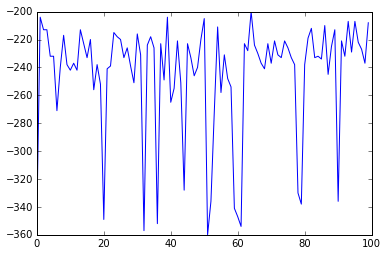

In [152]:
x = np.arange(0, plays, 1)
y = map(lambda x: UCTrews[1][x], x)

plt.plot(x, y)

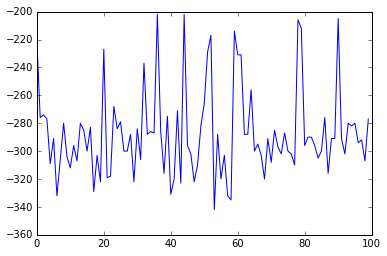

In [153]:
x = np.arange(0, plays, 1)
y = map(lambda x: UCTrews[2][x], x)

plt.plot(x, y)